# NeRF Training
Change the data folder and model name for your custom model

In [4]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tools import setup_experiment_folders
from dataset import get_rays
from model import Nerf
from ml_helpers import training

In [5]:
batch_size = 1024 # how many rays to use per batch. More rays means more GPU needed
height = 400 # image height
width = 400 # image width
imgs = 200 # ammount of images used for TRAINING in the dataset being used
dataset_path = 'data/test_missing'
pth_file = 'pigmeye.pth' # choose a name for your output model file!
experiment_name = "pigeye"

## Calculate rays from pose data
Find ray origins and directions for training and test data. This is done using the focal length for each camera pose, and the rotation and position of each camera pose data.

In [6]:
o, d, target_px_values = get_rays(dataset_path, mode='train')

dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)

dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(imgs, height, width, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(imgs, height, width, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(imgs, height, width, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)

#test_o, test_d, test_target_px_values = get_rays(dataset_path, mode='test')

## Model Training: train N models to ensemble
Adjust/tune hyperparameters as needed below.

Creating directory: /home/eherrin@ad.ufl.edu/code/gitlab_dev/nerf-3D-change/experiments/pigeye
Creating directory: /home/eherrin@ad.ufl.edu/code/gitlab_dev/nerf-3D-change/experiments/pigeye/models
Creating directory: /home/eherrin@ad.ufl.edu/code/gitlab_dev/nerf-3D-change/experiments/pigeye/figures
All required directories are set up.


100%|██████████| 7813/7813 [07:15<00:00, 17.93it/s]


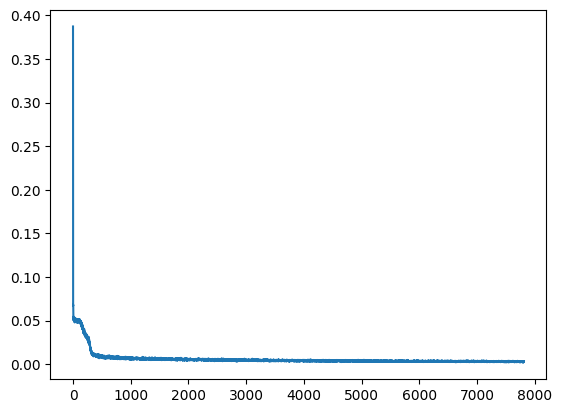

100%|██████████| 31250/31250 [28:17<00:00, 18.41it/s]


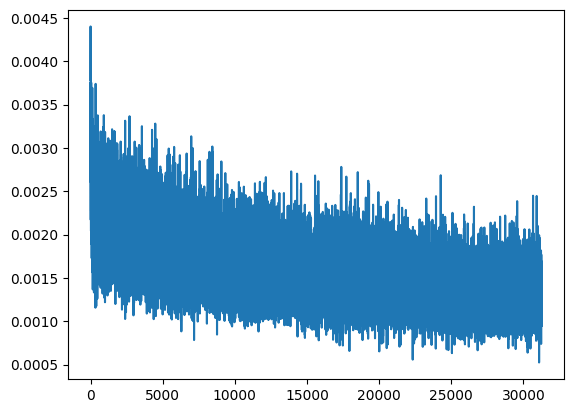

In [7]:
device = 'cuda'

tn = 1.
tf = 15.
nb_epochs = 1
lr = 1e-3
gamma = .5
nb_bins = 100

# train N models
N = 1
setup_experiment_folders(experiment_name)

for i in range(N):

    model = Nerf(hidden_dim=256).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

    training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, model_name="experiments/"+experiment_name+"/models/M"+str(i)+'.pth', device=device)
    plt.plot(training_loss)
    plt.show()
    training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, model_name="experiments/"+experiment_name+"/models/M"+str(i)+'.pth', device=device)
    plt.plot(training_loss)
    plt.show()

In [8]:
torch.save(model, "pigeye.pth")